In [30]:
from lib import Augmentation_methods
from lib import data_preparation
from lib import vae_augmentation

import matplotlib.pyplot as plt
from scipy.signal import stft
import numpy as np
import pandas as pd
from pathlib import Path

from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.regularizers import l2
from IPython.display import clear_output

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import pandas as pd
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam, SGD
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from scipy.signal import stft
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import MaxPooling2D ,Conv2D, Conv2DTranspose, Input, Flatten, Dense, Lambda, Reshape
import warnings
from IPython.display import clear_output
warnings.filterwarnings('ignore')

In [2]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve, classification_report
from sklearn.metrics import f1_score
from sklearn.metrics import auc
from matplotlib import pyplot
from numpy import sqrt
from numpy import argmax
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [3]:
BASEDIR = Path("/store/projects/fallki/")
FAKEDIR = BASEDIR / "Fake-Events" / "2. Fake-Events Messung"

# BASEDIR = pathlib.Path('/store/projects/fallki/')
# FAKEDIR = pathlib.Path('Fake-Events/2. Fake-Events Messung/')
df_fake = pd.read_parquet(BASEDIR / FAKEDIR / 'gSensoren_FakeEvents.parquet')

In [4]:
def SignalToSpectrum(signal, samplerate=1600):
    SIGNAL_LENGTH = samplerate * 10
    F = stft(signal[:SIGNAL_LENGTH], 1600, nperseg=128)[2]
    F = F[2:,]
    return np.expand_dims(np.abs(F), axis=2) # Add extra dimension for TF Conv2D

In [5]:
#To obtain the dummy data
dummy_lab_data = data_preparation.fake_lab_data()
dummy_data = dummy_lab_data[0]
dummy_dataframe =pd.DataFrame(dummy_data,columns=['z'])

/home/ing2146/Final/SNEHA/lib/data_preparation.py:202: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  All_Events_Data = np.array(All_Events_Data)[shuffler]
/home/ing2146/Final/SNEHA/lib/data_preparation.py:226: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  df_fake_dummy_Data = np.array(df_fake_dummy_Data)


In [7]:
index_list = []
for index,row in dummy_dataframe.iterrows():
    if row["z"][0] < 0:
        index_list.append(index)

dummy_data_df = dummy_dataframe.drop(index_list)

In [15]:
dummy_data_df.reset_index(drop=True, inplace=True)

#### Traditional Augmentation of dummy events

In [8]:
augmented_dummy = []

for i, event in enumerate(dummy_data_df.to_numpy().ravel()): 
    
    #Jittering
    Noise_dummy = Augmentation_methods.add_white_noise(event, 0.15) 
    augmented_dummy.append(Noise_dummy)
    
    #Jittering
    Noise_dummy1 = Augmentation_methods.add_white_noise(event, 0.12) 
    augmented_dummy.append(Noise_dummy1)
    
    #Jittering
    Noise_dummy2 = Augmentation_methods.add_white_noise(event, 0.08) 
    augmented_dummy.append(Noise_dummy2)
    
    #Jittering
    Noise_dummy2 = Augmentation_methods.add_white_noise(event, 0.05) 
    augmented_dummy.append(Noise_dummy2)
    
    #Magnitude Warping
    magnitude_warped_dummy =  Augmentation_methods.magnitudewarping(event,0.1, 20) 
    augmented_dummy.append(magnitude_warped_dummy[1])
    
    #Magnitude Warping
    magnitude_warped_dummy1 =  Augmentation_methods.magnitudewarping(event,0.1, 15) 
    augmented_dummy.append(magnitude_warped_dummy1[1])
    
    #Magnitude Warping
    magnitude_warped_dummy2 =  Augmentation_methods.magnitudewarping(event,0.1, 10) 
    augmented_dummy.append(magnitude_warped_dummy2[1])
    
    #Window Warping
    window_warped_dummy = Augmentation_methods.windowWarp(event, window_ratio=0.1, scales=[0.5, 2.]) 
    augmented_dummy.append(window_warped_dummy)
    
    #Jittering + Magnitude warping
    curve_JMW, jittered_magnitude_warped_dummy  =  Augmentation_methods.magnitudewarping((Augmentation_methods.add_white_noise(event, 0.50)),0.1, 10)
    augmented_dummy.append(jittered_magnitude_warped_dummy)
    
    #Jittering + window warping
    Jittered_window_warped_dummy = Augmentation_methods.windowWarp((Augmentation_methods.add_white_noise(event, 0.50)), window_ratio=0.1, scales=[0.5, 2.])
    augmented_dummy.append(Jittered_window_warped_dummy)
    
    #magnitude warping + window warping
    mag_warped  =  Augmentation_methods.magnitudewarping(event,0.1, 10)
    mag_window_warped_dummy = Augmentation_methods.windowWarp(mag_warped[1] , window_ratio=0.1, scales=[0.5, 2.])
    augmented_dummy.append(mag_window_warped_dummy)
          
    
augmented_dummy_array = np.array(augmented_dummy)    

/tmp/ipykernel_1477247/2480421356.py:51: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  augmented_dummy_array = np.array(augmented_dummy)


In [9]:
augmented_dummy_array_df =pd.DataFrame(augmented_dummy_array,columns=['z'])

## Data Preparation

### Augmented data 

In [10]:
M = []
for i in range(len(augmented_dummy_array_df)):
    M.append({"event": "Dummy" ,
              "istSturz": 1,
              "signalLenght": len(augmented_dummy_array_df.z[i]),
              "spectrum": SignalToSpectrum(augmented_dummy_array_df.z[i])})
augmented_df = pd.DataFrame.from_dict(M)

In [11]:
# normalize the spectrum to facilitate training 
augmented_df["normalizedSpectrum"] = augmented_df["spectrum"] / augmented_df["spectrum"].map(np.max).max()

# shuffle the final dataframe
augmented_df = augmented_df.sample(frac=1).reset_index(drop=True)

### Dummy events(k) for test

In [17]:
R = []
for i in range(len(dummy_data_df)):
    R.append({"event": "Dummy" ,
              "istSturz": 1,
              "signalLenght": len(dummy_data_df.z[i]),
              "spectrum": SignalToSpectrum(dummy_data_df.z[i])})
test_part_df = pd.DataFrame.from_dict(R)

In [18]:
# normalize the spectrum to facilitate training
test_part_df["normalizedSpectrum"] = test_part_df["spectrum"] / test_part_df["spectrum"].map(np.max).max()

### VAE augmentation of dummy events

In [22]:
normalization_factor = test_part_df["spectrum"].map(np.max).max()

In [24]:
X_train_vae = np.stack(test_part_df["normalizedSpectrum"])
y_train_vae = test_part_df["istSturz"]

In [25]:
def sample_z(args):
        z_mean, z_log_var = args
        eps = K.random_normal(shape=(K.shape(z_mean)[0], K.int_shape(z_mean)[1]))
        return z_mean + K.exp(z_log_var / 2) * eps

In [28]:
latent_dim = 2 # Number of latent dim parameters

# Encoder 
input_data = Input(shape=(63,251,1), name='encoder_input')
x = layers.Conv2D(32,3, padding='same', activation='relu')(input_data)
x = layers.Conv2D(64,3, padding='same', activation='relu')(x)
conv_shape = K.int_shape(x) #Shape of conv to be provided to decoder
x = layers.Flatten()(x)
x = layers.Dense(16, activation='relu')(x)
z_mean = layers.Dense(latent_dim, name='latent_mu')(x)   #Mean values of encoded input
z_log_var = layers.Dense(latent_dim, name='latent_sigma')(x) 
z = Lambda(sample_z, output_shape=(latent_dim, ), name='z')([z_mean, z_log_var])
encoder = Model(input_data, [z_mean, z_log_var, z], name='encoder')

# Decoder
decoder_input = Input(shape=(latent_dim, ), name='decoder_input')
x = Dense(conv_shape[1]*conv_shape[2]*conv_shape[3], activation='relu')(decoder_input)
x = Reshape((conv_shape[1], conv_shape[2],conv_shape[3]))(x)
x = Conv2DTranspose(64,3, padding='same', activation='relu')(x)
x = Conv2DTranspose(32,3, padding='same', activation='sigmoid')(x)
decoder_output = Conv2DTranspose(1, 3, activation="sigmoid", padding="same", name='decoder_output')(x)
decoder = Model(decoder_input, decoder_output, name='decoder')

2023-01-09 22:20:50.209997: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [31]:
# Training VAE model with train data 
vae = vae_augmentation.VAE(encoder, decoder)
vae.compile(optimizer = keras.optimizers.Adam())
vae.fit(X_train_vae, epochs = 30,batch_size=9)

Epoch 1/30
8/8 [==============================] - 4s 386ms/step - loss: 4749.8401 - reconstruction_loss: 3330.3174 - kl_loss: 620.6042
Epoch 2/30
8/8 [==============================] - 3s 364ms/step - loss: 1308.0953 - reconstruction_loss: 1007.1058 - kl_loss: 1.0240
Epoch 3/30
8/8 [==============================] - 3s 388ms/step - loss: 347.8904 - reconstruction_loss: 295.5051 - kl_loss: 0.0730
Epoch 4/30
8/8 [==============================] - 3s 376ms/step - loss: 212.1020 - reconstruction_loss: 202.6568 - kl_loss: 0.0848
Epoch 5/30
8/8 [==============================] - 3s 389ms/step - loss: 206.3524 - reconstruction_loss: 205.9400 - kl_loss: 0.1043
Epoch 6/30
8/8 [==============================] - 3s 369ms/step - loss: 194.1655 - reconstruction_loss: 197.4539 - kl_loss: 0.0964
Epoch 7/30
8/8 [==============================] - 3s 366ms/step - loss: 194.7183 - reconstruction_loss: 198.4433 - kl_loss: 0.0846
Epoch 8/30
8/8 [==============================] - 3s 377ms/step - loss: 201.2

3/3 [==============================] - 0s 48ms/step


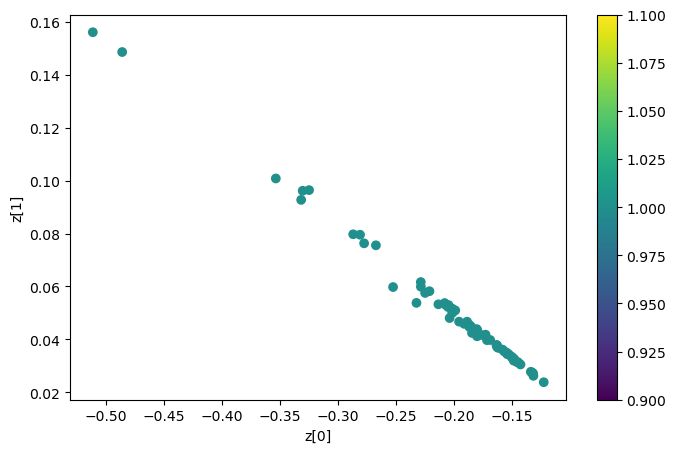

In [33]:
# predicting the distribution
z_mean, z_log_var, z = vae.encoder.predict(X_train_vae)
plt.figure(figsize=(8, 5))
plt.scatter(z_mean[:, 0], z_mean[:, 1], c=test_part_df["istSturz"])
plt.colorbar()
plt.xlabel("z[0]")
plt.ylabel("z[1]")
plt.show()

In [ ]:
# predicting usinbg decoder - Augmentation
augmented_data= vae_augmentation.plot_latent_space(vae, z_mean, decoder, n = 20)

In [35]:
augmented_data = np.expand_dims(np.array(augmented_data), axis=3)

In [36]:
V = []
for i in range(len(augmented_data)):
    V.append({"event": "Dummy" ,
              "istSturz": 1,
              "signalLenght": 16000,
              "spectrum": normalization_factor * augmented_data[i],
              "normalizedSpectrum":augmented_data[i]})
vae_df = pd.DataFrame.from_dict(V)

In [37]:
vae_df

,event,istSturz,signalLenght,spectrum,normalizedSpectrum
0,Dummy,1,16000,"[[[41.26008], [13.263667], [6.470637], [2.7136...","[[[0.11516498], [0.0370215], [0.018060818], [0..."
1,Dummy,1,16000,"[[[41.26008], [13.269875], [6.475111], [2.7158...","[[[0.11516498], [0.037038825], [0.018073305], ..."
2,Dummy,1,16000,"[[[41.26008], [13.276091], [6.479596], [2.7179...","[[[0.11516498], [0.037056174], [0.018085824], ..."
3,Dummy,1,16000,"[[[41.26008], [13.282319], [6.484093], [2.7201...","[[[0.11516498], [0.03707356], [0.018098377], [..."
4,Dummy,1,16000,"[[[41.26008], [13.28855], [6.4885974], [2.7223...","[[[0.11516498], [0.037090953], [0.01811095], [..."
...,...,...,...,...,...
395,Dummy,1,16000,"[[[41.26008], [13.251719], [6.448481], [2.7038...","[[[0.11516498], [0.03698815], [0.017998977], [..."
396,Dummy,1,16000,"[[[41.26008], [13.257914], [6.452909], [2.7060...","[[[0.11516498], [0.03700544], [0.018011335], [..."
397,Dummy,1,16000,"[[[41.26008], [13.26412], [6.4573483], [2.7081...","[[[0.11516498], [0.037022762], [0.018023727], ..."
398,Dummy,1,16000,"[[[41.26008], [13.270332], [6.4617996], [2.710...","[[[0.11516498], [0.037040103], [0.018036151], ..."


### Positive events

In [38]:
L = []
for (teensy, event, run, rep), ss in df_fake.groupby(["teensy", "experiment", "run", "rep"]):
    L.append({"event": event,
              "run": run,
              "istSturz": int(event == "Dummy"),
              "signalLenght": len(ss["z"]),
              "spectrum": SignalToSpectrum(ss["z"])})
df = pd.DataFrame.from_dict(L)
df.drop('run', inplace=True, axis=1)

In [39]:
# normalize the spectrum to facilitate training
df["normalizedSpectrum"] = df["spectrum"] / df["spectrum"].map(np.max).max()

In [40]:
# Dropping dummy events from the dataframe
df_drop = []
df_drop = df.drop(df[(df['event'] == "Dummy")].index)

### Append dataframe for training

In [41]:
final_df = []
final_df = df_drop.append(augmented_df)
final_df = final_df.append(vae_df)

In [42]:
#shuffle the final dataframe
final_df = final_df.sample(frac=1).reset_index(drop=True)

In [43]:
final_df

,event,istSturz,signalLenght,spectrum,normalizedSpectrum
0,Stuhl kippt,0,16008,"[[[218.41911813800112], [0.33612656613106867],...","[[[0.3192846357373647], [0.0004913491508605156..."
1,Dummy,1,15955,"[[[209.17584485485304], [0.9310416616637168], ...","[[[0.5428714670678734], [0.0024163208381895824..."
2,Getränkeflasche,0,16033,"[[[220.4186696196278], [0.17126796130126076], ...","[[[0.3222075761461155], [0.0002503591677492456..."
3,Dummy,1,15963,"[[[220.53189153500256], [0.33248110214614945],...","[[[0.572343673696807], [0.000862884066846574],..."
4,Dummy,1,15968,"[[[240.52395654036062], [0.3216951970200443], ...","[[[0.6242288312144258], [0.0008348915414977383..."
...,...,...,...,...,...
2128,Wasserkasten,0,16075,"[[[220.43590661138143], [0.4942664043115013], ...","[[[0.32223277314663534], [0.000722517654146495..."
2129,Dummy,1,16040,"[[[220.3227535006939], [0.45225477744912995], ...","[[[0.5718009003589792], [0.0011737311958396881..."
2130,Dummy,1,15963,"[[[220.65838527293653], [1.0517484190050441], ...","[[[0.5726719613207187], [0.0027295895833851004..."
2131,Dummy,1,16003,"[[[217.99331415222784], [1.3117367467834482], ...","[[[0.565755335406559], [0.003404334055049706],..."


### Input and target split for train and test

#### Input and target for Train

In [44]:
X = np.stack(final_df["normalizedSpectrum"].to_list())
y = final_df["istSturz"].to_numpy()

#### Input and target for test

In [45]:
X_tst = np.stack(test_part_df["normalizedSpectrum"].to_list())
y_tst = test_part_df["istSturz"].to_numpy()

### Model

#### Cross-validation

In [46]:
# https://github.com/christianversloot/machine-learning-articles/blob/main/how-to-use-k-fold-cross-validation-with-keras.md
# https://www.kaggle.com/code/franklemuchahary/basic-cnn-keras-with-cross-validation
# https://machinelearningmastery.com/k-fold-cross-validation/
# https://stats.stackexchange.com/questions/186337/average-roc-for-repeated-10-fold-cross-validation-with-probability-estimates

In [47]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix

In [48]:
# Model configuration
#batch_size = 50
loss_function = "binary_crossentropy"
no_epochs = 75
optimizer = "adam"
verbosity = 0
num_folds = 5

In [49]:
# Define per-fold score containers <-- these are new
acc_per_fold = []
loss_per_fold = []

In [50]:
# defind array fot ROC, Precision-recall curve and confusion martrix
roc_values = []
precision_recall_values = []
auc = []
confusion_matrices = []

In [51]:
# Define the K-fold Cross Validator
skfold = StratifiedKFold(n_splits=num_folds, shuffle=True)

# K-fold Cross Validation model evaluation
fold_no = 1
for train, test in skfold.split(X, y):
    mdl = Sequential()
    mdl.add(Conv2D(8, (63, 5), activation="relu", input_shape=(63, 251, 1)))
    mdl.add(MaxPooling2D((1, 4)))
    mdl.add(Flatten())
    mdl.add(Dense(1,activation="sigmoid"))
    #mdl.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
    #mdl.summary()

    # Compile the model
    mdl.compile(loss=loss_function,
                    optimizer=optimizer,
                    metrics=['accuracy'])


      # Generate a print
    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold_no} ...')

    # Fit data to model
    history = mdl.fit(X[train], y[train],
                  epochs=no_epochs,
                  verbose=verbosity)

    # Generate generalization metrics
    scores = mdl.evaluate(X[test], y[test], verbose=0)
    print(f'Score for fold {fold_no}: {mdl.metrics_names[0]} of {scores[0]}; {mdl.metrics_names[1]} of {scores[1]*100}%')
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])
    
    # Confusion Matrix
    # Predict the labels for the test set
    y_pred = mdl.predict(X[test,])
    
    # Convert the predicted labels to a binary form
    y_pred_binary = np.where(y_pred > 0.10, 1, 0)
    
    
    # ROC AND PRECISION RECALL VALUES
    fpr, tpr, thresholds = roc_curve(y[test], y_pred)
    roc_values.append((fpr, tpr,thresholds))
    
    
    precision, recall, thresholds_1 = precision_recall_curve(y[test], y_pred)
    precision_recall_values.append((precision, recall,thresholds_1)) 
    
    auc = roc_auc_score(y[test], y_pred)
     
    #confusion matrix
    confusion_matrices.append(confusion_matrix(y[test], y_pred_binary))


    # Increase fold number
    fold_no = fold_no + 1

------------------------------------------------------------------------
Training for fold 1 ...
Score for fold 1: loss of 0.0022577079944312572; accuracy of 100.0%
14/14 [==============================] - 0s 3ms/step
------------------------------------------------------------------------
Training for fold 2 ...
Score for fold 2: loss of 0.0063360934145748615; accuracy of 99.76580739021301%
14/14 [==============================] - 0s 3ms/step
------------------------------------------------------------------------
Training for fold 3 ...
Score for fold 3: loss of 0.0026808385737240314; accuracy of 100.0%
14/14 [==============================] - 0s 3ms/step
------------------------------------------------------------------------
Training for fold 4 ...
Score for fold 4: loss of 0.01384385209530592; accuracy of 99.53051805496216%
14/14 [==============================] - 0s 3ms/step
------------------------------------------------------------------------
Training for fold 5 ...
Score for

In [52]:
# == Provide average scores ==
print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(acc_per_fold)):
    print('------------------------------------------------------------------------')
    print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}%')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
print(f'> Loss: {np.mean(loss_per_fold)}')
print('------------------------------------------------------------------------')

------------------------------------------------------------------------
Score per fold
------------------------------------------------------------------------
> Fold 1 - Loss: 0.0022577079944312572 - Accuracy: 100.0%
------------------------------------------------------------------------
> Fold 2 - Loss: 0.0063360934145748615 - Accuracy: 99.76580739021301%
------------------------------------------------------------------------
> Fold 3 - Loss: 0.0026808385737240314 - Accuracy: 100.0%
------------------------------------------------------------------------
> Fold 4 - Loss: 0.01384385209530592 - Accuracy: 99.53051805496216%
------------------------------------------------------------------------
> Fold 5 - Loss: 0.0040808143094182014 - Accuracy: 100.0%
------------------------------------------------------------------------
Average scores for all folds:
> Accuracy: 99.85926508903503 (+- 0.18773806187013378)
> Loss: 0.005839861277490854
------------------------------------------------

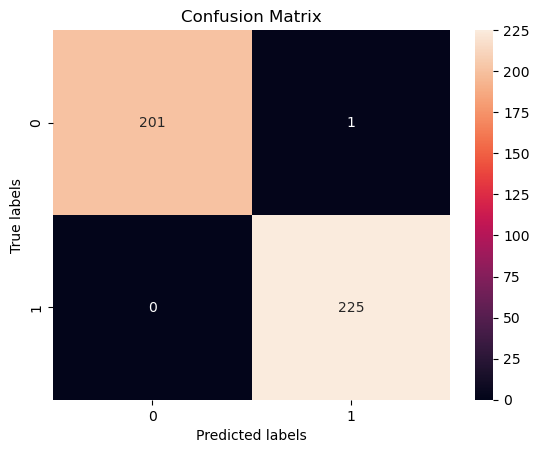

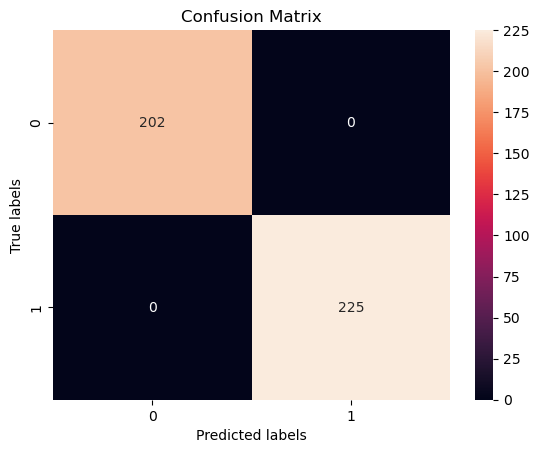

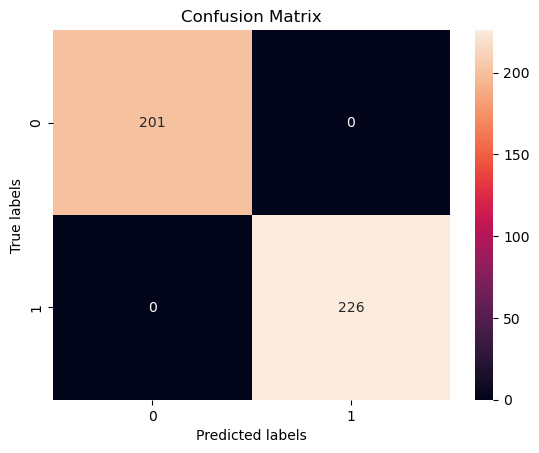

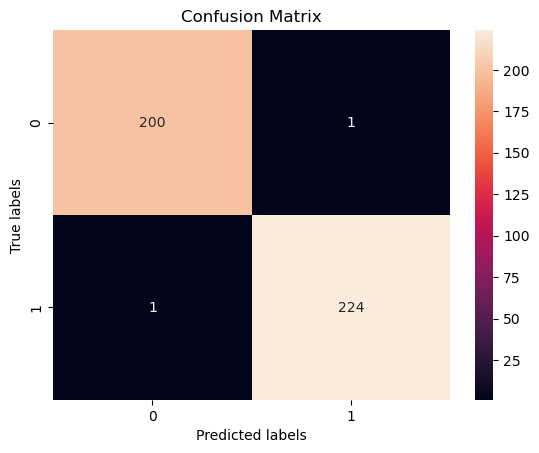

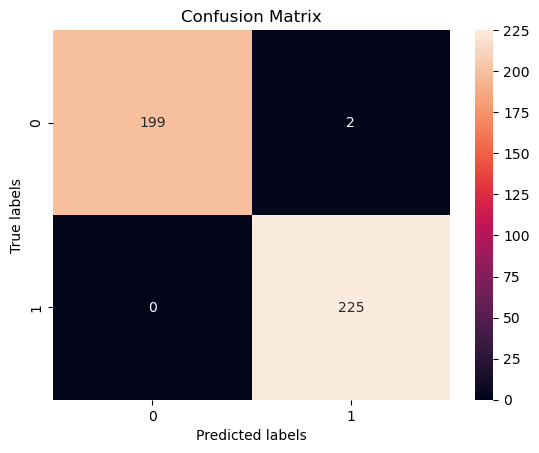

In [53]:
# Plot the confusion matrix values for each fold on the same graph
for cm in confusion_matrices:
    ax= pyplot.subplot()
    sns.heatmap(cm, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation
    # labels, title and ticks
    ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels');
    ax.set_title('Confusion Matrix');
    ax.xaxis.set_ticklabels(['0', '1'])
    ax.yaxis.set_ticklabels(['0', '1'])
    pyplot.show() 

# Show the plot
plt.show()

In [54]:
pyplot.rcParams.update({'font.size': 8})

In [ ]:
tprs = []
base_fpr = np.linspace(0, 1, 101)
pyplot.figure(figsize=(5, 5))
pyplot.axes().set_aspect('equal', 'datalim')

For fold 1 optimal Threshold=0.915505, G-Mean=1.000
For fold 2 optimal Threshold=0.160470, G-Mean=1.000
For fold 3 optimal Threshold=0.816510, G-Mean=1.000
For fold 4 optimal Threshold=0.918375, G-Mean=0.996
For fold 5 optimal Threshold=0.907064, G-Mean=1.000
mean Threshold=1.000000, G-Mean=0.995


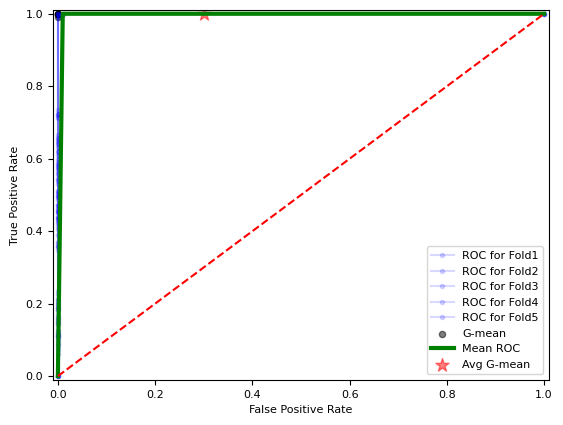

In [57]:
# Plot the ROC and precision-recall values for each fold on the same graph
tprs = []

i = 1
j = 1
    
# ROC CURVE
for fpr, tpr,thresholds in roc_values:
    
    gmeans = sqrt(tpr * (1-fpr))
    # locate the index of the largest g-mean
    ix = argmax(gmeans)
    print('For fold '  +str(i), 'optimal Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))
    
    # plot the roc curve for the model
    pyplot.plot(fpr, tpr,'b', alpha=0.15, marker='.', label='ROC for Fold' +str(i))
    
    tpr_new = np.interp(base_fpr, fpr, tpr)
    tpr_new[0] = 0.0
    tprs.append(tpr_new)
    
   
    if i == num_folds:
        pyplot.scatter(fpr[ix], tpr[ix],s=20,alpha=0.5, marker='o', color='black', label='G-mean')
        pyplot.legend()
    else:
        pyplot.scatter(fpr[ix], tpr[ix],s=20,alpha=0.5, marker='o', color='black')  
        pyplot.legend()
        
    i = i + 1
     
tprs = np.array(tprs)
mean_tprs = tprs.mean(axis=0)
std = tprs.std(axis=0)

tprs_upper = np.minimum(mean_tprs + std, 1)
tprs_lower = mean_tprs - std


gmeans_new = sqrt(mean_tprs * (1-base_fpr))
# locate the index of the largest g-mean
iy = argmax(gmeans_new)
print('mean Threshold=%f, G-Mean=%.3f' % (thresholds[iy], gmeans_new[iy]))

pyplot.plot(base_fpr, mean_tprs, 'g',linewidth=3.0, label='Mean ROC')
pyplot.scatter(base_fpr[ix], mean_tprs[ix],s=100,alpha=0.5, marker="*", color='Red', label='Avg G-mean')
pyplot.fill_between(base_fpr, tprs_lower, tprs_upper, color='grey', alpha=0.2)

pyplot.plot([0, 1], [0, 1],'r--')
pyplot.xlim([-0.01, 1.01])
pyplot.ylim([-0.01, 1.01])
pyplot.ylabel('True Positive Rate')
pyplot.xlabel('False Positive Rate')
pyplot.legend()
pyplot.show()



In [58]:
prc = []
base_recall = np.linspace(0, 1, 101)

For fold 1 Best Threshold=0.915505, F-Score=1.000
For fold 2 Best Threshold=0.160470, F-Score=1.000
For fold 3 Best Threshold=0.816510, F-Score=1.000
For fold 4 Best Threshold=0.041879, F-Score=0.996
For fold 5 Best Threshold=0.907064, F-Score=1.000


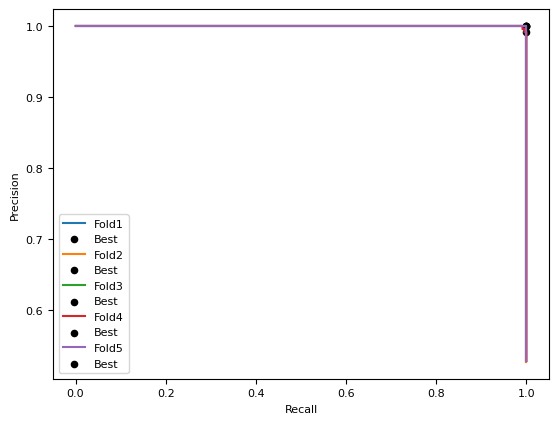

In [64]:
ix = 0 
j = 1
# PRECISION RECALL CURVE
for precision, recall, thresholds_1 in precision_recall_values:
    
     # convert to f score
    fscore = (2 * precision * recall) / (precision + recall)
    # locate the index of the largest f score
    ix = argmax(fscore)
    print('For fold '  +str(j),'Best Threshold=%f, F-Score=%.3f' % (thresholds_1[ix], fscore[ix]))

    pyplot.plot(recall, precision, marker='none', label='Fold' + str(j))
    
    
    pyplot.scatter(recall[ix], precision[ix],s=20, marker='o', color='black', label='Best')
    # axis labels
    pyplot.xlabel('Recall')
    pyplot.ylabel('Precision')
    pyplot.legend()
    
    j = j + 1


# Show the plot
pyplot.show()

In [63]:
ypred = mdl.predict(X_tst).ravel()
threshold = 0.10
pd.crosstab(test_part_df['event'], ypred >= threshold)

3/3 [==============================] - 0s 2ms/step


col_0,True
event,
Dummy,66
